# 05: Publication Figures

This notebook generates publication-ready figures for the paper.

## Figures
1. Sycophancy distribution across models
2. Sycophancy effect on battle outcomes
3. Heterogeneous effects by topic
4. Sycophancy vs politeness relationship

In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Publication style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.figsize': (6, 4),
})

FIGURES_DIR = project_root / 'paper' / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# Load data
from quant_syco.data.process import build_battle_table
from quant_syco.features.topics import compute_topic_features
from quant_syco.features.lexical import compute_response_length_features
from quant_syco.config import LABELS_DIR

battles = build_battle_table()
battles = compute_topic_features(battles)
battles = compute_response_length_features(battles)

labels = pd.read_parquet(list(LABELS_DIR.glob('labels_*_merged.parquet'))[0])
df = battles.merge(labels, on='question_id', how='inner')

# Prepare modeling data
df_model = df[df['winner'].isin(['model_a', 'model_b'])].copy()
df_model['a_wins'] = (df_model['winner'] == 'model_a').astype(int)
df_model['syco_diff'] = df_model['sycophancy_a'] - df_model['sycophancy_b']

print(f"Loaded {len(df):,} battles")

Loading cached data from /Users/nijjohnson/Projects/quant-sycophantic/data/raw/lmsys_raw.parquet

Processing 33,000 battles...

Built battle table with 33,000 rows

Columns: ['question_id', 'user_id', 'judge', 'ts_utc', 'model_a', 'model_b', 'winner', 'language', 'user_prompt', 
'assistant_a', 'assistant_b', 'turn', 'anony', 'openai_moderation', 'toxic_chat_tag']

Loaded 33,132 battles


## Figure 1: Sycophancy Score Distribution

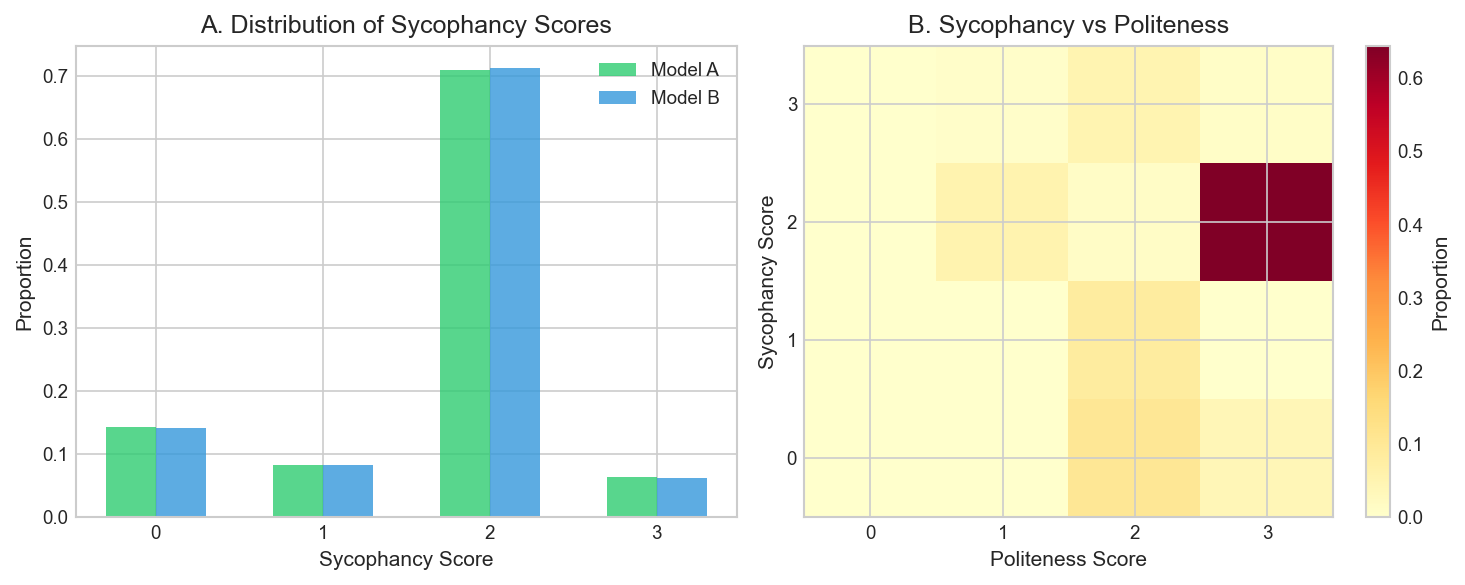

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Panel A: Score distribution
for side, color, label in [('a', '#2ecc71', 'Model A'), ('b', '#3498db', 'Model B')]:
    col = f'sycophancy_{side}'
    counts = df[col].value_counts(normalize=True).sort_index()
    axes[0].bar(counts.index + (0.15 if side == 'b' else -0.15), 
                counts.values, width=0.3, color=color, label=label, alpha=0.8)

axes[0].set_xlabel('Sycophancy Score')
axes[0].set_ylabel('Proportion')
axes[0].set_title('A. Distribution of Sycophancy Scores')
axes[0].set_xticks([0, 1, 2, 3])
axes[0].legend()

# Panel B: Sycophancy vs Politeness
joint = pd.crosstab(df['sycophancy_a'], df['politeness_a'], normalize=True)
im = axes[1].imshow(joint.values, cmap='YlOrRd', aspect='auto', origin='lower')
axes[1].set_xlabel('Politeness Score')
axes[1].set_ylabel('Sycophancy Score')
axes[1].set_title('B. Sycophancy vs Politeness')
axes[1].set_xticks([0, 1, 2, 3])
axes[1].set_yticks([0, 1, 2, 3])
plt.colorbar(im, ax=axes[1], label='Proportion')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1_sycophancy_distribution.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig1_sycophancy_distribution.png', bbox_inches='tight')
plt.show()

## Figure 2: Sycophancy Effect on Battle Outcomes

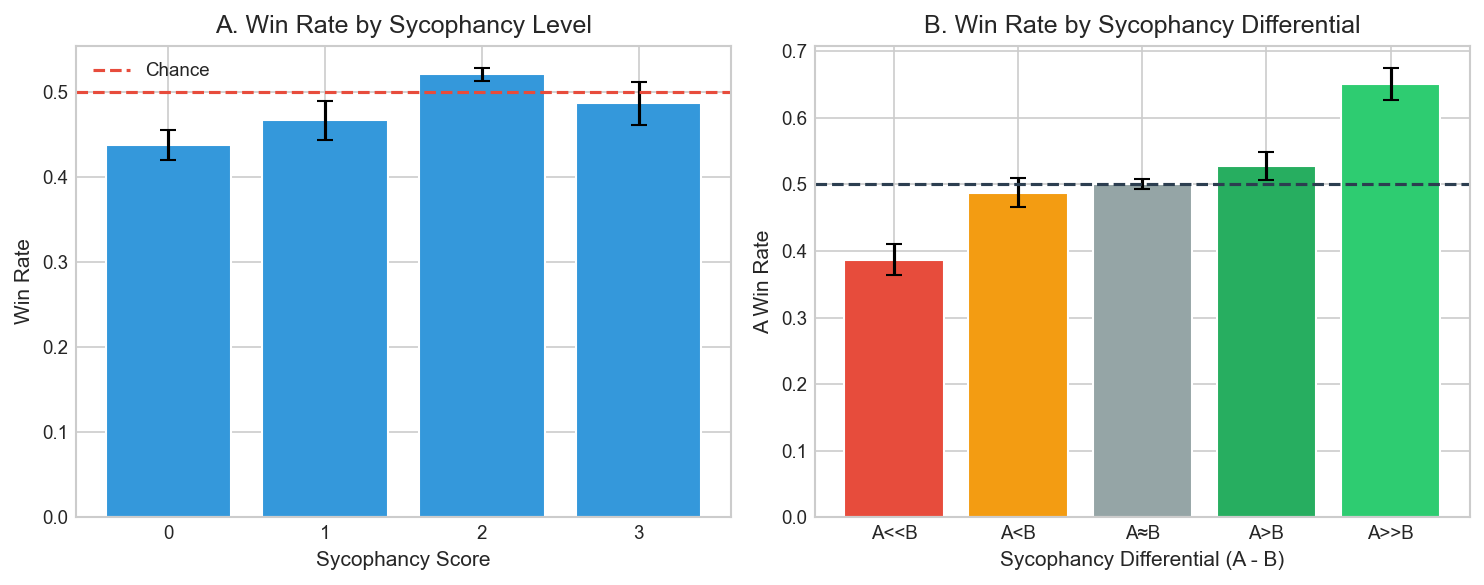

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Panel A: Win rate by sycophancy level
win_by_syco = df_model.groupby('sycophancy_a').agg({
    'a_wins': ['mean', 'count']
}).droplevel(0, axis=1)
win_by_syco.columns = ['win_rate', 'n']
win_by_syco['se'] = np.sqrt(win_by_syco['win_rate'] * (1 - win_by_syco['win_rate']) / win_by_syco['n'])

axes[0].bar(win_by_syco.index, win_by_syco['win_rate'], 
            yerr=1.96*win_by_syco['se'], capsize=4, color='#3498db', edgecolor='white')
axes[0].axhline(y=0.5, color='#e74c3c', linestyle='--', linewidth=1.5, label='Chance')
axes[0].set_xlabel('Sycophancy Score')
axes[0].set_ylabel('Win Rate')
axes[0].set_title('A. Win Rate by Sycophancy Level')
axes[0].set_xticks([0, 1, 2, 3])
axes[0].legend(loc='upper left')

# Panel B: Win rate by differential
df_model['syco_diff_cat'] = pd.cut(
    df_model['syco_diff'], 
    bins=[-4, -1.5, -0.5, 0.5, 1.5, 4],
    labels=['A<<B', 'A<B', 'A≈B', 'A>B', 'A>>B']
)

win_by_diff = df_model.groupby('syco_diff_cat', observed=True).agg({
    'a_wins': ['mean', 'count']
}).droplevel(0, axis=1)
win_by_diff.columns = ['win_rate', 'n']
win_by_diff['se'] = np.sqrt(win_by_diff['win_rate'] * (1 - win_by_diff['win_rate']) / win_by_diff['n'])

x = np.arange(len(win_by_diff))
colors = ['#e74c3c', '#f39c12', '#95a5a6', '#27ae60', '#2ecc71']
axes[1].bar(x, win_by_diff['win_rate'], yerr=1.96*win_by_diff['se'], 
            capsize=4, color=colors, edgecolor='white')
axes[1].axhline(y=0.5, color='#2c3e50', linestyle='--', linewidth=1.5)
axes[1].set_xticks(x)
axes[1].set_xticklabels(win_by_diff.index)
axes[1].set_xlabel('Sycophancy Differential (A - B)')
axes[1].set_ylabel('A Win Rate')
axes[1].set_title('B. Win Rate by Sycophancy Differential')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig2_sycophancy_outcomes.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig2_sycophancy_outcomes.png', bbox_inches='tight')
plt.show()

## Figure 3: Heterogeneous Effects by Topic

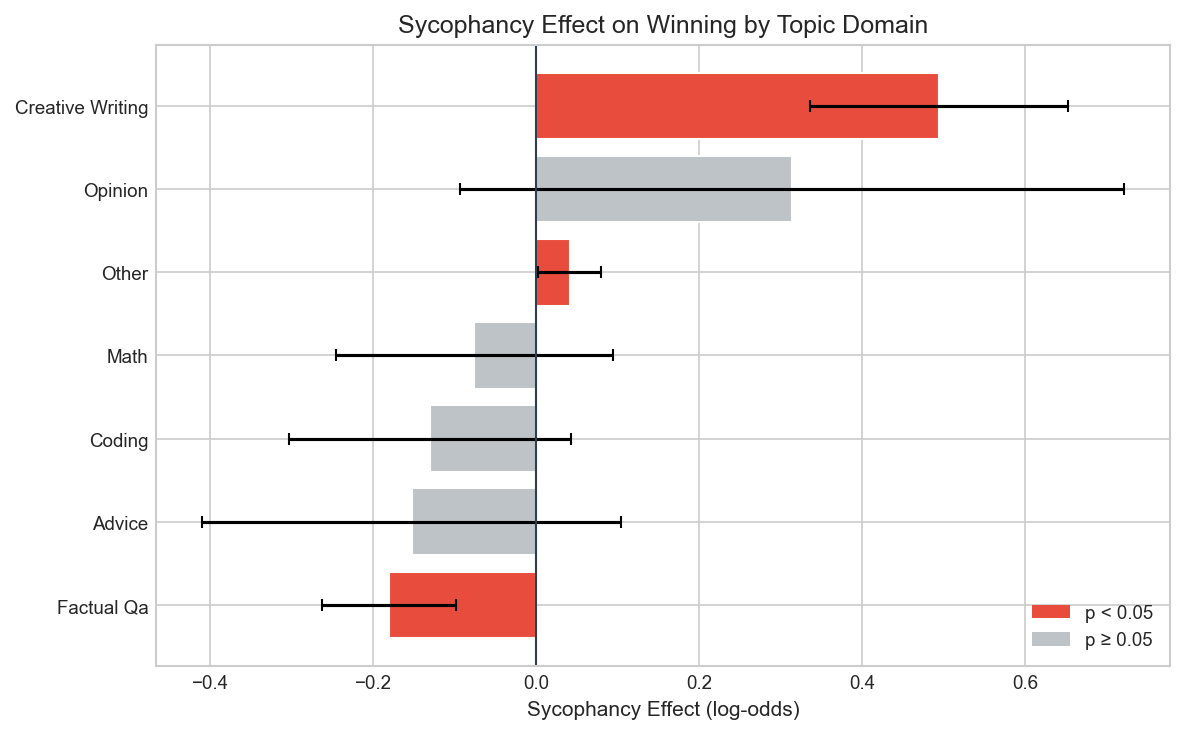

In [5]:
from quant_syco.analysis.causal import run_heterogeneous_effects

df_model['polite_diff'] = df_model['politeness_a'] - df_model['politeness_b']
df_model['length_diff'] = df_model['assistant_a_word_count'] - df_model['assistant_b_word_count']

het_effects = run_heterogeneous_effects(
    df_model.dropna(subset=['syco_diff', 'polite_diff', 'length_diff', 'topic', 'a_wins']),
    outcome_col='a_wins',
    sycophancy_col='syco_diff',
    moderator_col='topic',
    control_cols=['polite_diff', 'length_diff'],
)

het_effects = het_effects.sort_values('sycophancy_coef')

fig, ax = plt.subplots(figsize=(8, 5))

y_pos = np.arange(len(het_effects))
colors = ['#e74c3c' if p < 0.05 else '#bdc3c7' for p in het_effects['sycophancy_pval']]

ax.barh(y_pos, het_effects['sycophancy_coef'], 
        xerr=[het_effects['sycophancy_coef'] - het_effects['sycophancy_ci_lower'],
              het_effects['sycophancy_ci_upper'] - het_effects['sycophancy_coef']],
        capsize=3, color=colors, edgecolor='white')

ax.axvline(x=0, color='#2c3e50', linestyle='-', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(het_effects['level'].str.replace('_', ' ').str.title())
ax.set_xlabel('Sycophancy Effect (log-odds)')
ax.set_title('Sycophancy Effect on Winning by Topic Domain')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='p < 0.05'),
    Patch(facecolor='#bdc3c7', label='p ≥ 0.05')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig3_heterogeneous_effects.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig3_heterogeneous_effects.png', bbox_inches='tight')
plt.show()

## Figure 4: Model Comparison

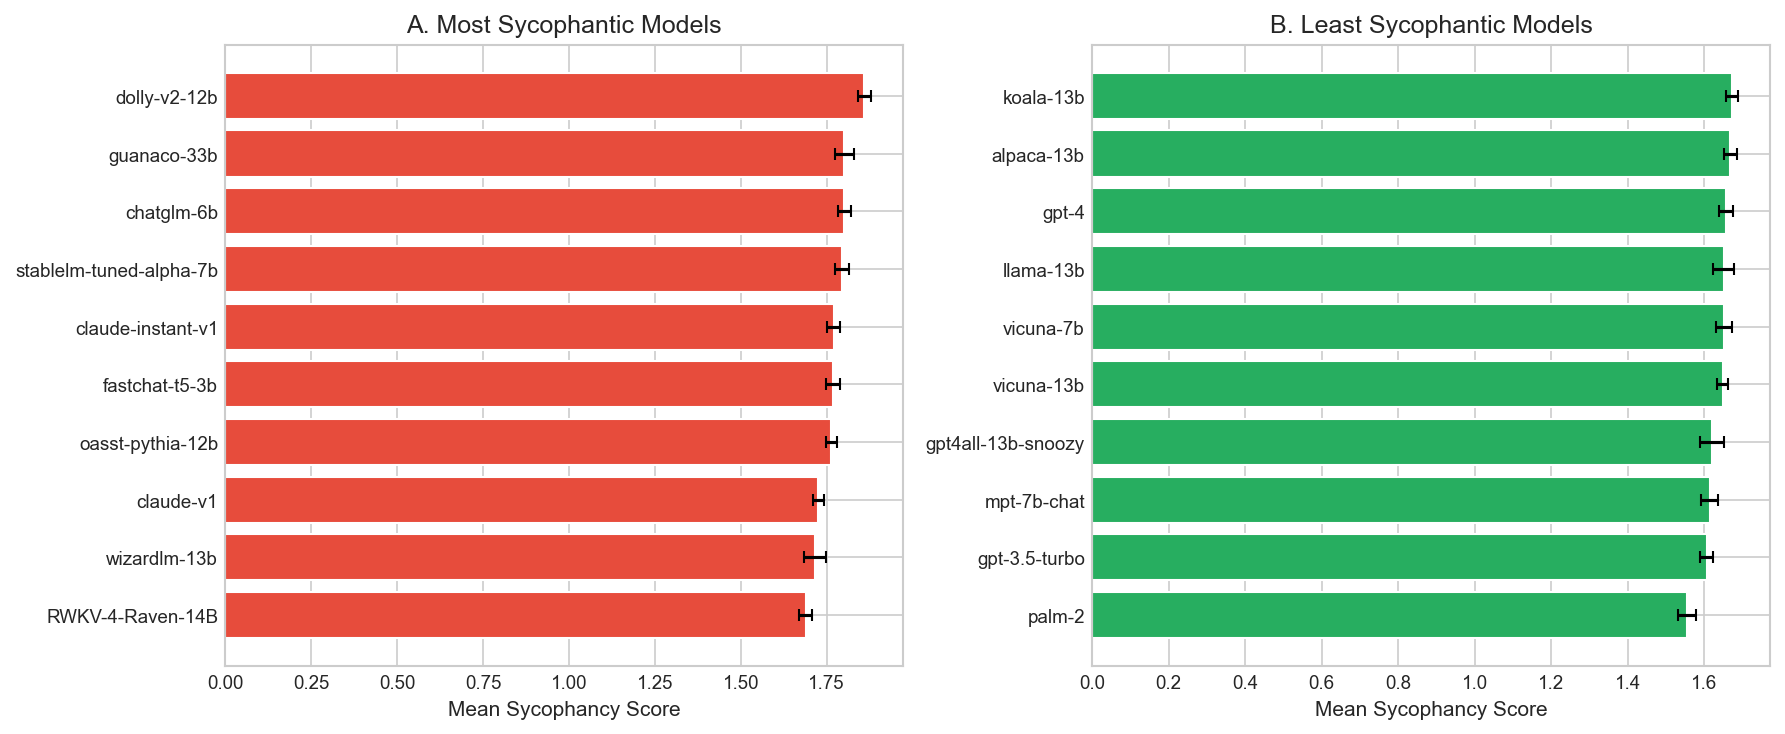

In [6]:
from quant_syco.analysis.descriptive import compute_sycophancy_by_model

by_model = compute_sycophancy_by_model(df, 'model_a', 'sycophancy_a')
by_model = by_model[by_model['n_samples'] >= 100]  # Filter for sufficient sample

# Top 10 and bottom 10
top_10 = by_model.head(10)
bottom_10 = by_model.tail(10)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: Most sycophantic
y_pos = np.arange(len(top_10))
axes[0].barh(y_pos, top_10['mean_sycophancy'], 
             xerr=top_10['std_sycophancy']/np.sqrt(top_10['n_samples']),
             color='#e74c3c', capsize=3, edgecolor='white')
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(top_10['model_a'])
axes[0].set_xlabel('Mean Sycophancy Score')
axes[0].set_title('A. Most Sycophantic Models')
axes[0].invert_yaxis()

# Panel B: Least sycophantic
y_pos = np.arange(len(bottom_10))
axes[1].barh(y_pos, bottom_10['mean_sycophancy'], 
             xerr=bottom_10['std_sycophancy']/np.sqrt(bottom_10['n_samples']),
             color='#27ae60', capsize=3, edgecolor='white')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(bottom_10['model_a'])
axes[1].set_xlabel('Mean Sycophancy Score')
axes[1].set_title('B. Least Sycophantic Models')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig4_model_comparison.pdf', bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig4_model_comparison.png', bbox_inches='tight')
plt.show()

## Summary

In [7]:
print("Figures saved to:", FIGURES_DIR)
for f in sorted(FIGURES_DIR.glob('*.pdf')):
    print(f"  - {f.name}")

Figures saved to: /Users/nijjohnson/Projects/quant-sycophantic/paper/figures
  - fig1_sycophancy_distribution.pdf
  - fig2_sycophancy_outcomes.pdf
  - fig3_heterogeneous_effects.pdf
  - fig4_model_comparison.pdf
